# Fiber models - comparison of myelinated and unmyelinated fiber responses to gaussian acoustic source

### Imports

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from PySONIC.core import PulsedProtocol
from PySONIC.utils import logger, si_format, getPow10
from PySONIC.postpro import detectSpikes
from MorphoSONIC.core import IextraFiber, SonicFiber, ExtracellularCurrent, myelinatedFiberReilly, unmyelinatedFiberSundt, strengthDuration, GaussianAcousticSource
from MorphoSONIC.plt import strengthDurationCurve, SectionCompTimeSeries
from MorphoSONIC.plot_SDcurves import plotSDcurves

#Folder used to store the strength duration data
outdir='strengthDurationData'
logger.setLevel(logging.WARNING)

## Gaussian acoustic stimulation

In [2]:
# Gaussian acoustic stimulation
fiberClass = 'acoustic_gaussian'
# Fdrive = 500 kHz
sigma_range = [1e-4, 1e-3, 10e-3]

#Pulsed protocol
toffset = 20e-3  # s
n_dur = 20
tstim_range = np.logspace(-5, 0, n_dur)  # s

In [3]:
# Myelinated fiber
fiberType = 'reilly'
diameters = [10e-6, 20e-6]  #(m)
# Sonophore: a=32 nm, fs=1

logger.setLevel(logging.WARNING)
Athr_dict = {}
for sigma in sigma_range:
    for fiberD in diameters:  #(m)
        df = strengthDuration(fiberType, fiberClass, fiberD, tstim_range, toffset=toffset, outdir=outdir, sigma=sigma)
        Athr = np.absolute(df.values[:,1])      
        Athr_dict[f'reilly σ={(sigma*1e3):.1f}mm, d={(fiberD*1e6):.1f}um'] = Athr

In [4]:
# Unmyelinated fiber
fiberType = 'sundt'
diameters = [0.8e-6, 1.5e-6]  #(m)

logger.setLevel(logging.WARNING)
for sigma in sigma_range:
    for fiberD in diameters:  #(m)
        df = strengthDuration(fiberType, fiberClass, fiberD, tstim_range, toffset=toffset, outdir=outdir, sigma=sigma)
        Athr = np.absolute(df.values[:,1])      
        Athr_dict[f'sundt σ ={(sigma*1e3):.1f}mm, d={(fiberD*1e6):.1f}um'] = Athr

<IPython.core.display.Javascript object>


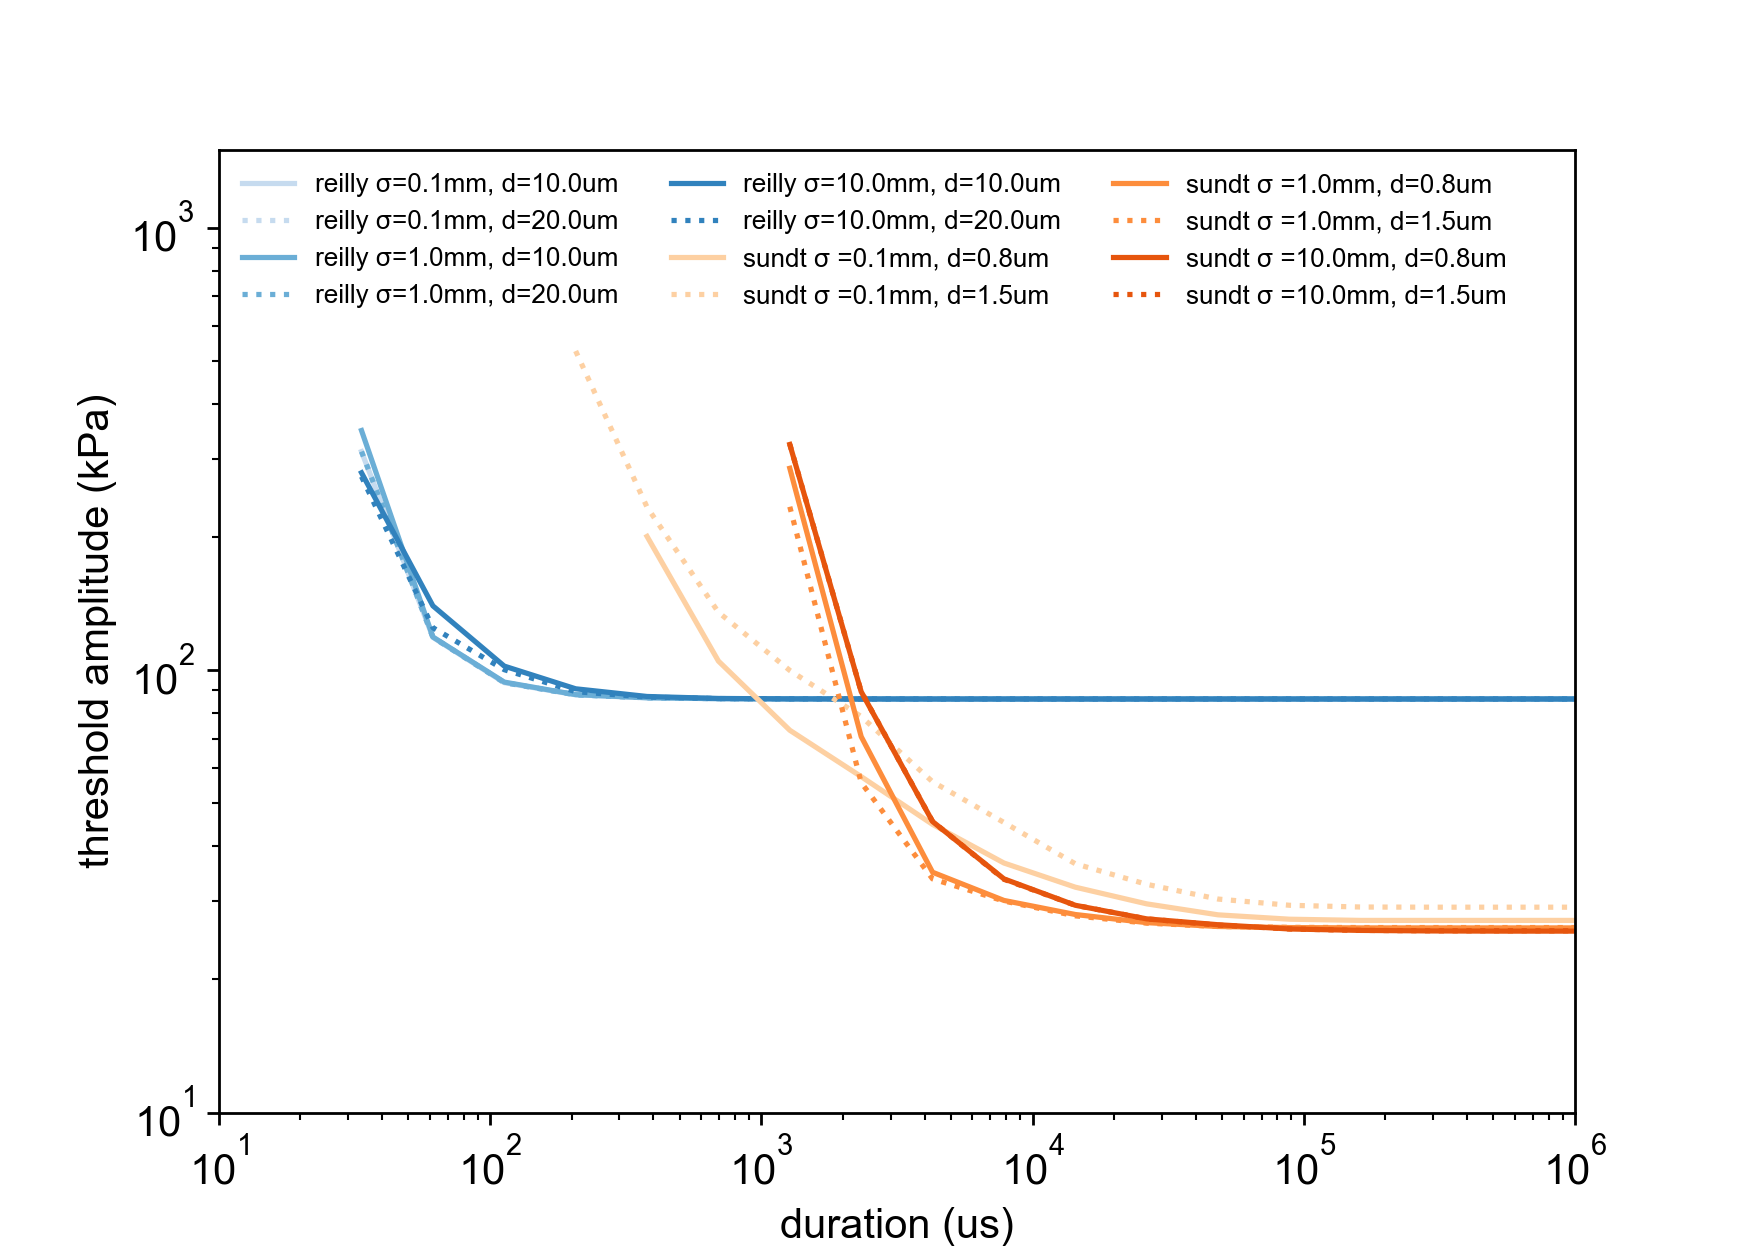

In [7]:
# Plot strength-duration curve
%matplotlib notebook
fig, ax = plt.subplots(figsize=(7,5))
fs=12
xname='duration'
xfactor=1e6
xunit='s'
yname='amplitude'
yfactor=1e-3
yunit='Pa'
prefix = si_format(1 / yfactor, space='')[1:]
ax.set_title(f' ', fontsize=fs)
ax.set_xlabel(f'{xname} ({si_format(1 / xfactor, space="")[1:]}{xunit})', fontsize=fs)
ax.set_ylabel(f'threshold {yname} ({prefix}{yunit})', fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
colors = plt.get_cmap('tab20c').colors
colors = [colors[3], colors[1], colors[0], colors[7], colors[5], colors[4]]
for i, k in enumerate(Athr_dict.keys()):
    i = float(i)
    if int(i / 2) == i/2:
        ax.plot(tstim_range * xfactor, Athr_dict[k] * yfactor, label=k, color=colors[int(i/2)])
    else:
        ax.plot(tstim_range * xfactor, Athr_dict[k] * yfactor, label=k, color=colors[int((i-1)/2)], linestyle=':')
ax.set_xlim(tstim_range.min() * xfactor, tstim_range.max() * xfactor)
#ymin = np.nanmin([np.nanmin(v) for v in Athr_dict.values()])
#ymax = np.nanmax([np.nanmax(v) for v in Athr_dict.values()])
#ymin = getPow10(ymin * yfactor ,'down')
#ymax = getPow10(ymax * yfactor ,'up')
ymin = 1e4 * yfactor
ymax = 1.5e6 * yfactor
ax.set_ylim(ymin, ymax)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.legend(fontsize=fs/1.6, frameon=False, loc='upper left', ncol=3)

### Gaussian acoustic stimulation (low sigma) of unmyelinated fibers

In [8]:
Athr_dict = {}
sigma_range = np.logspace(-6, -4, 6)
#sigma_range = [1e-6]
n_dur = 8
tstim_range = np.logspace(-3, 0, n_dur)  # s

# Unmyelinated fiber
fiberType = 'sundt'
fiberD = 0.8e-6  #(m)

logger.setLevel(logging.WARNING)
for i, sigma in enumerate(sigma_range): 
    df = strengthDuration(fiberType, fiberClass, fiberD, tstim_range, toffset=toffset, outdir=outdir, sigma=sigma)
    Athr = np.absolute(df.values[:,1])      
    Athr_dict[f'sundt sigma={(sigma*1e3):.3f}mm'] = Athr

<IPython.core.display.Javascript object>


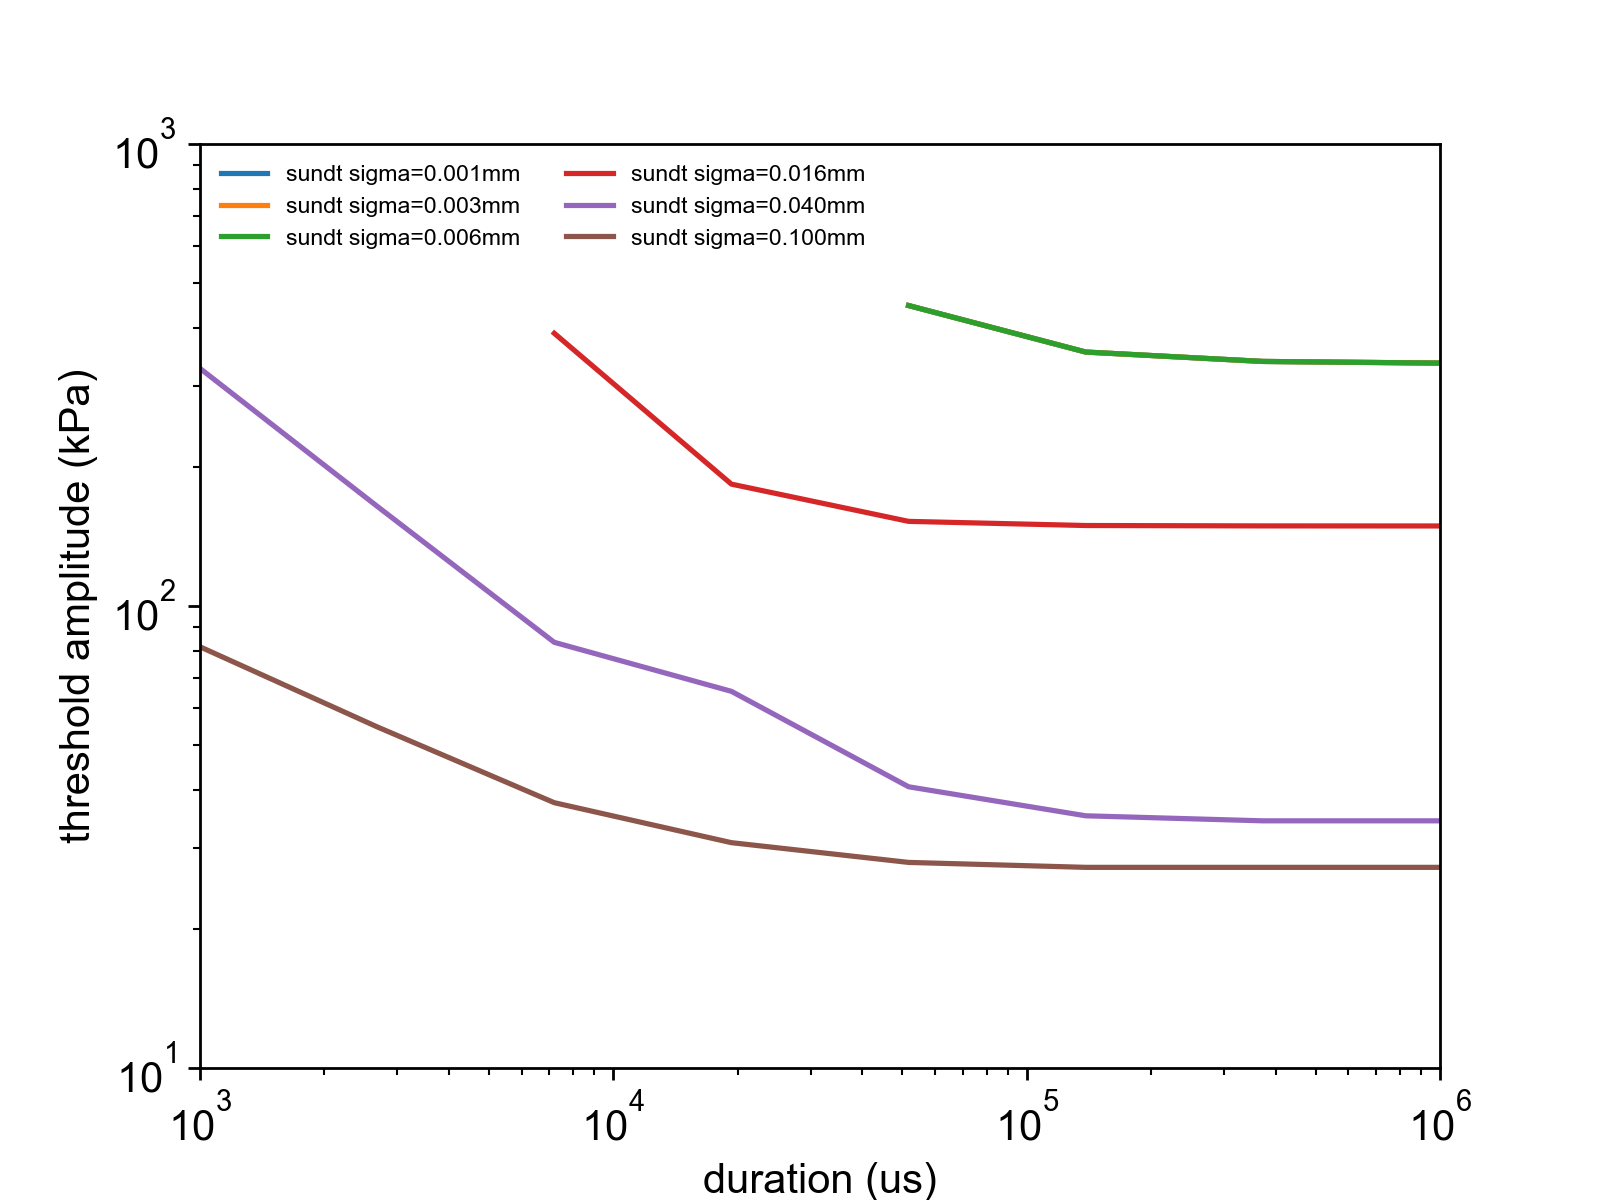

In [6]:
# Plot strength-duration curve
title = ' '
#title = 'SD curve - gaussian acoustic stimulation varying sigma'
%matplotlib notebook
colors = plt.get_cmap('tab20c').colors
colors = [colors[7], colors[6], colors[5], colors[4], colors[3], colors[2], colors[1], colors[0]]
fig2 = strengthDurationCurve(
    title, tstim_range, Athr_dict,
    yname='amplitude', yfactor=1e-3, yunit='Pa',
    scale='log', plot_chr=False)

In [9]:
logger.setLevel(logging.WARNING)
# Stimulation
tstim = 1e-1 
toffset = 20e-3  # s
pp = PulsedProtocol(tstim, toffset)
Fdrive = 500e3
sigma_range = sigma_range = np.logspace(-6, -4, 10)

#Fiber
fiberClass = SonicFiber
fiberD = 0.8e-6  #(m)
fiber = unmyelinatedFiberSundt(fiberClass, fiberD)

thr = np.zeros(len(sigma_range))
for i, sigma in enumerate(sigma_range):
    source = GaussianAcousticSource(0, sigma, Fdrive)
    thr[i] = fiber.titrate(source, pp) 

<IPython.core.display.Javascript object>


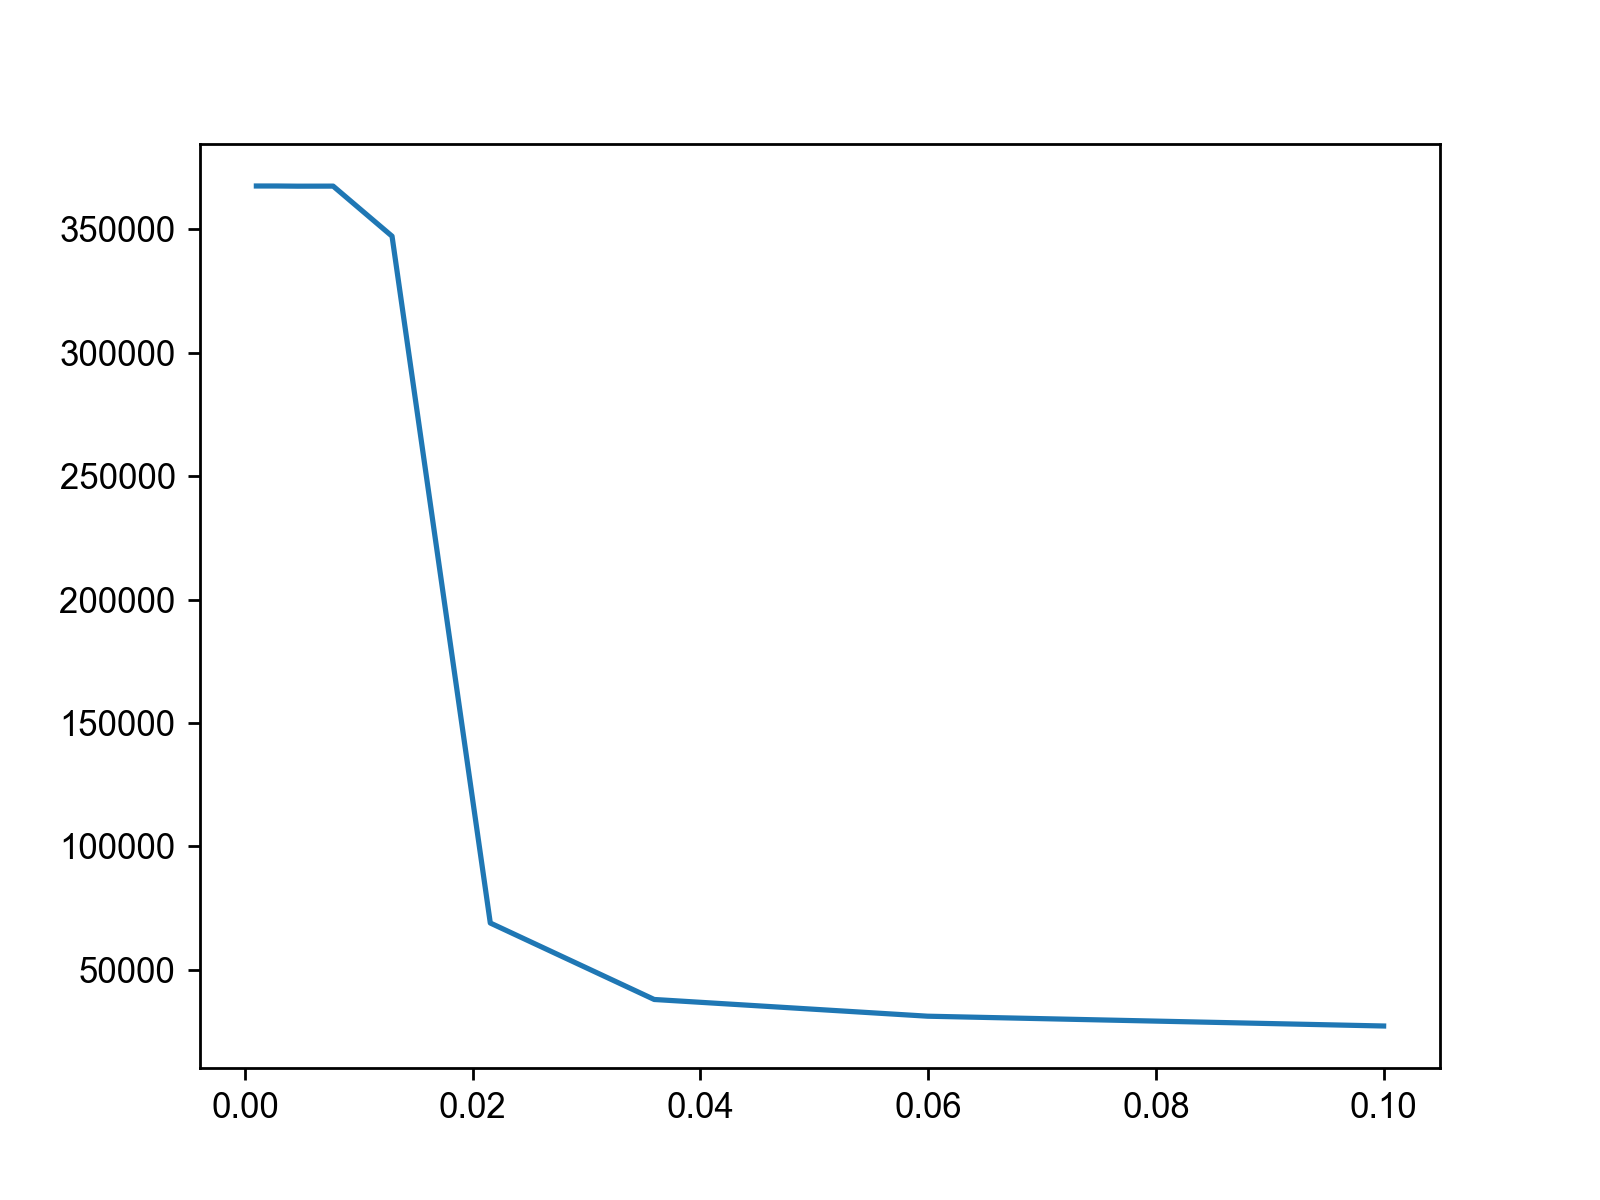

In [21]:
%matplotlib notebook
plt.plot(sigma_range*1e3, thr)

## Firing rate analysis

In [71]:
# Gaussian acoustic stimulation
Fdrive = 500e3
sigma = 1e-3
source = GaussianAcousticSource(0, sigma, Fdrive)

#Pulsed protocol
toffset = 10e-3  # s
ton = 1e-4  # s
toff = 1.5e-3
prf = 1 / (ton + toff)
dc = ton * prf   # ton / (ton + toff)
tstim = 1 / prf + ton
pp = PulsedProtocol(tstim, toffset, prf, dc)

<IPython.core.display.Javascript object>


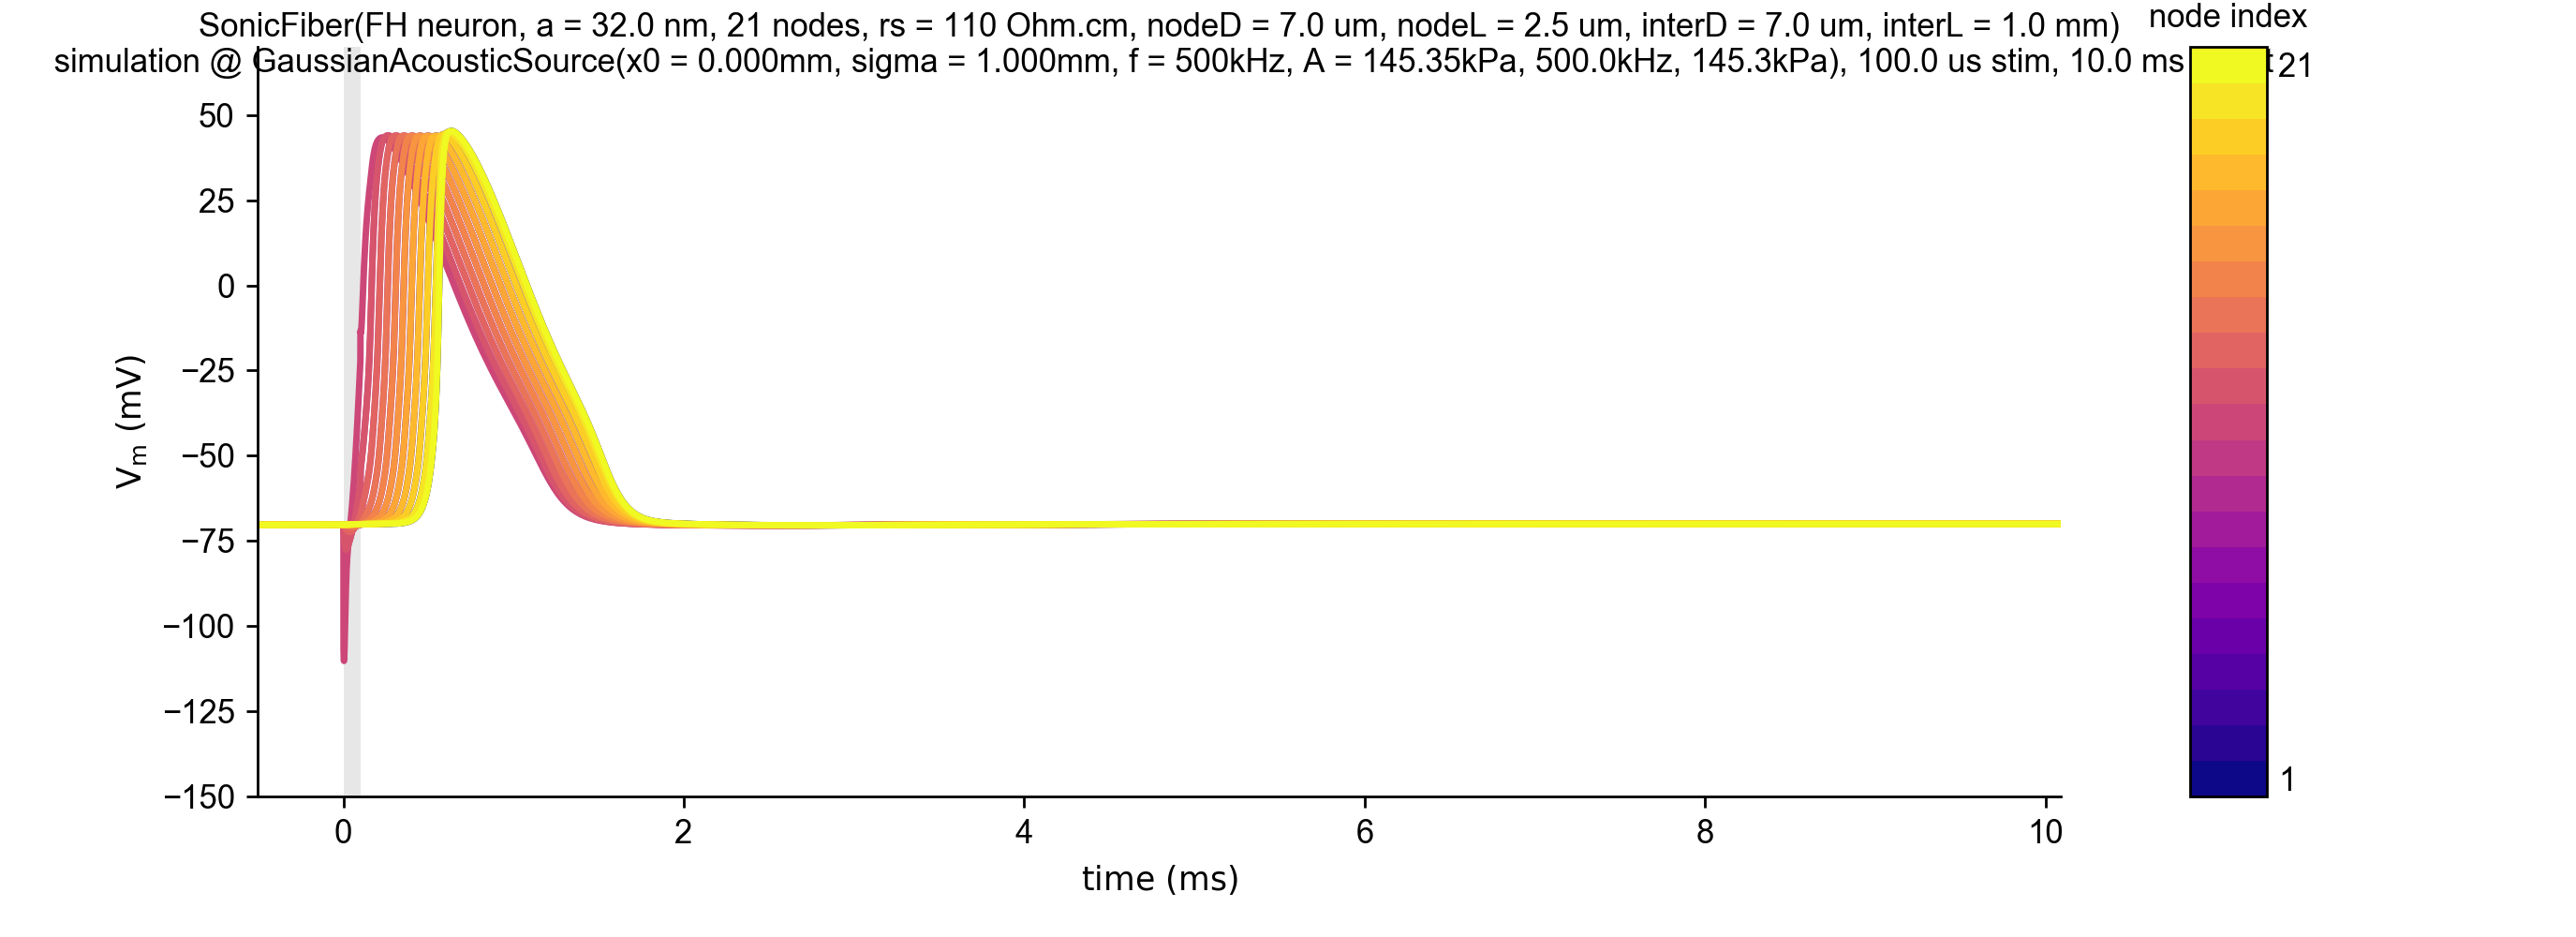

96897.2020929268 PulsedProtocol(100.0us, 10.0ms, 100.0Hz, 1.00)


<IPython.core.display.Javascript object>


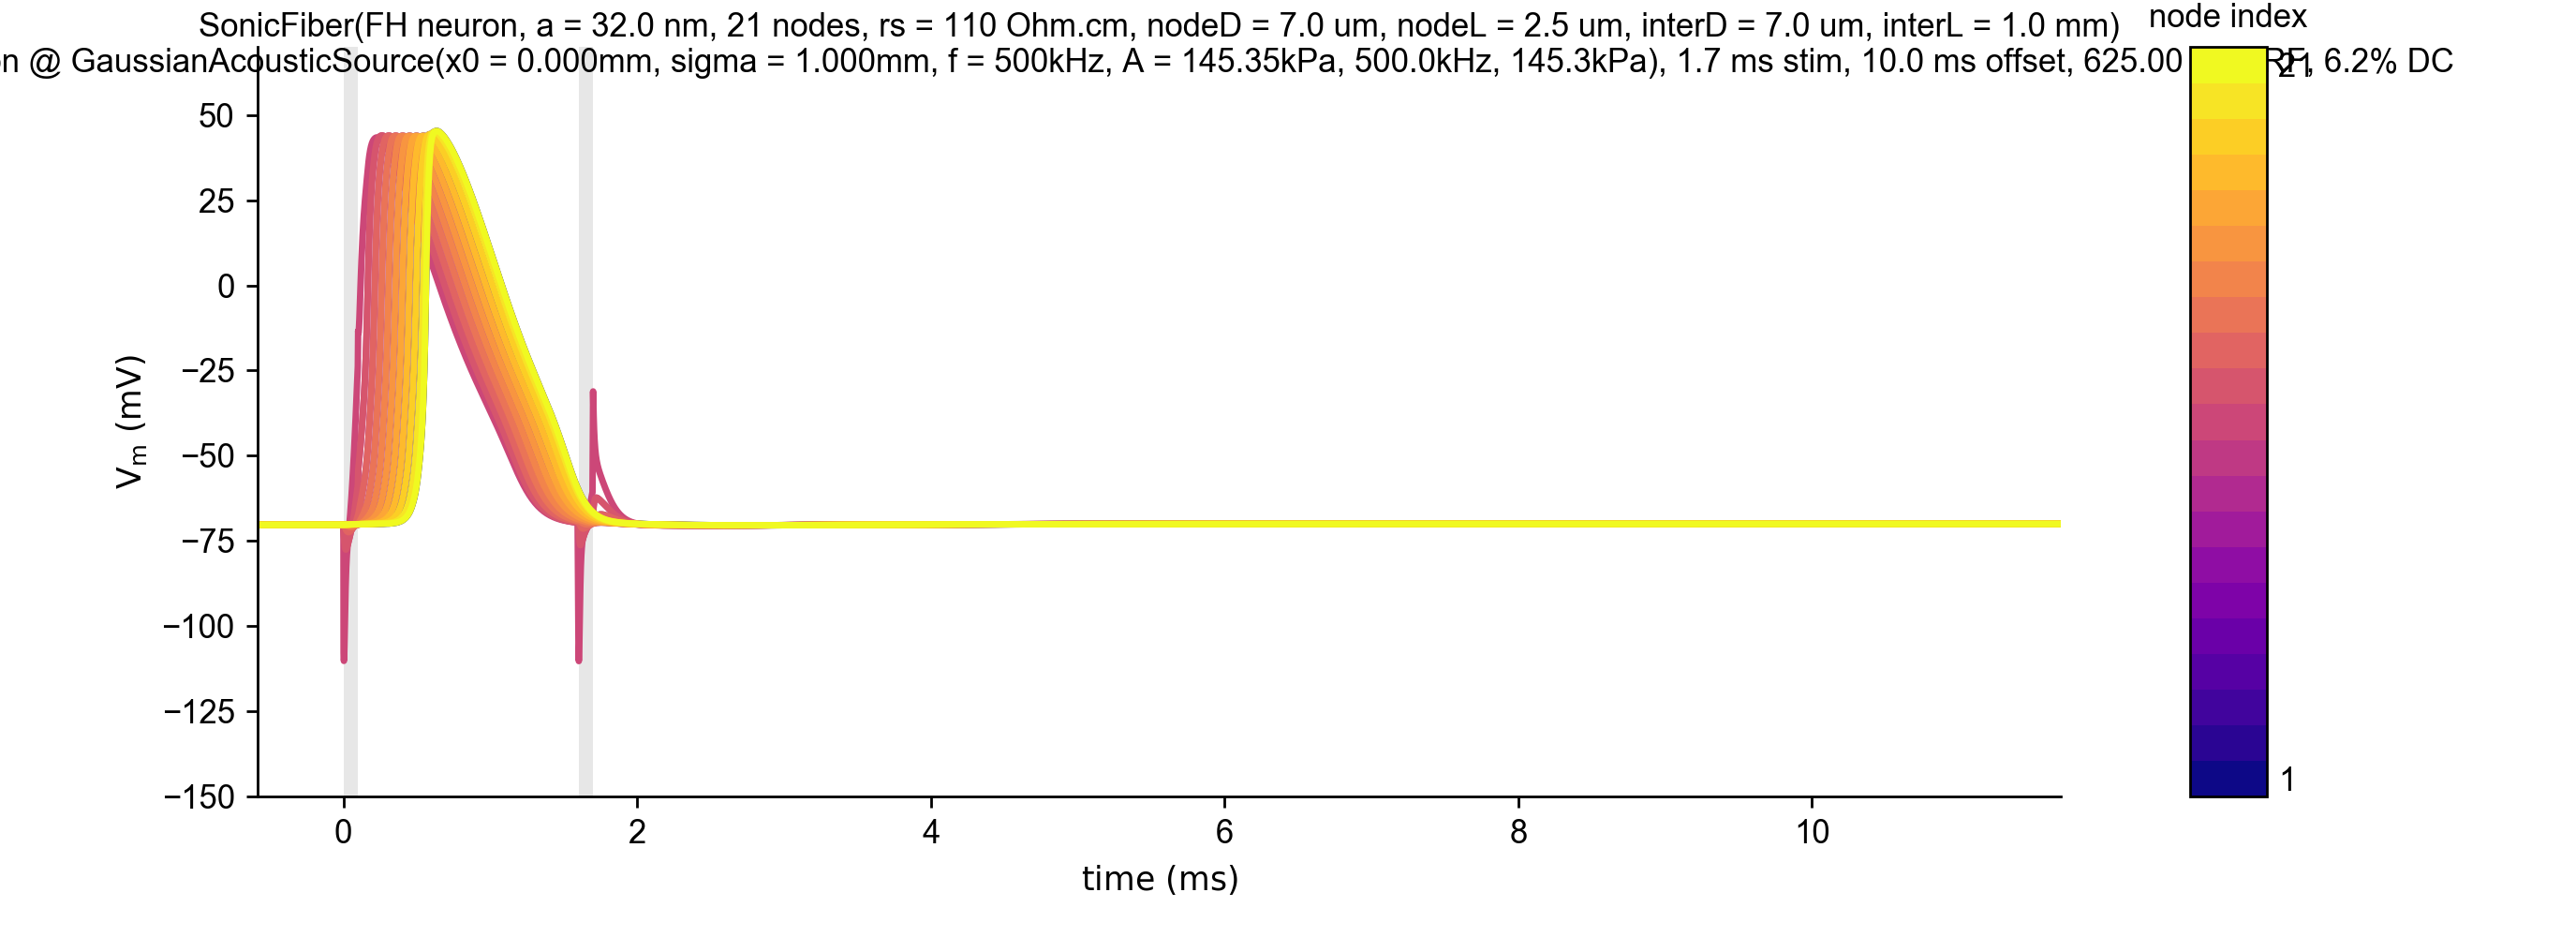

False


In [73]:
# Myelinated fiber
fiberType = 'reilly'
fiberD = 10e-6  #(m)
fiber_class = SonicFiber
fiber = myelinatedFiberReilly(fiber_class, fiberD)

# Find the excitation threshold
pp = PulsedProtocol(ton, toffset)
Athr = fiber.titrate(source, pp)
source = GaussianAcousticSource(0, sigma, Fdrive, 1.5 * Athr)
data, meta= fiber.simulate(source, pp)
fig1 = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
print(Athr, pp)

pp = PulsedProtocol(tstim, toffset, prf, dc)
data, meta= fiber.simulate(source, pp)
fig2 = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()

nspikes_start = detectSpikes(data[fiber.ids[0]])[0].size
nspikes_end = detectSpikes(data[fiber.ids[-1]])[0].size
double_spike = (nspikes_start == nspikes_end) and (nspikes_start == 2)

print(double_spike)

<IPython.core.display.Javascript object>


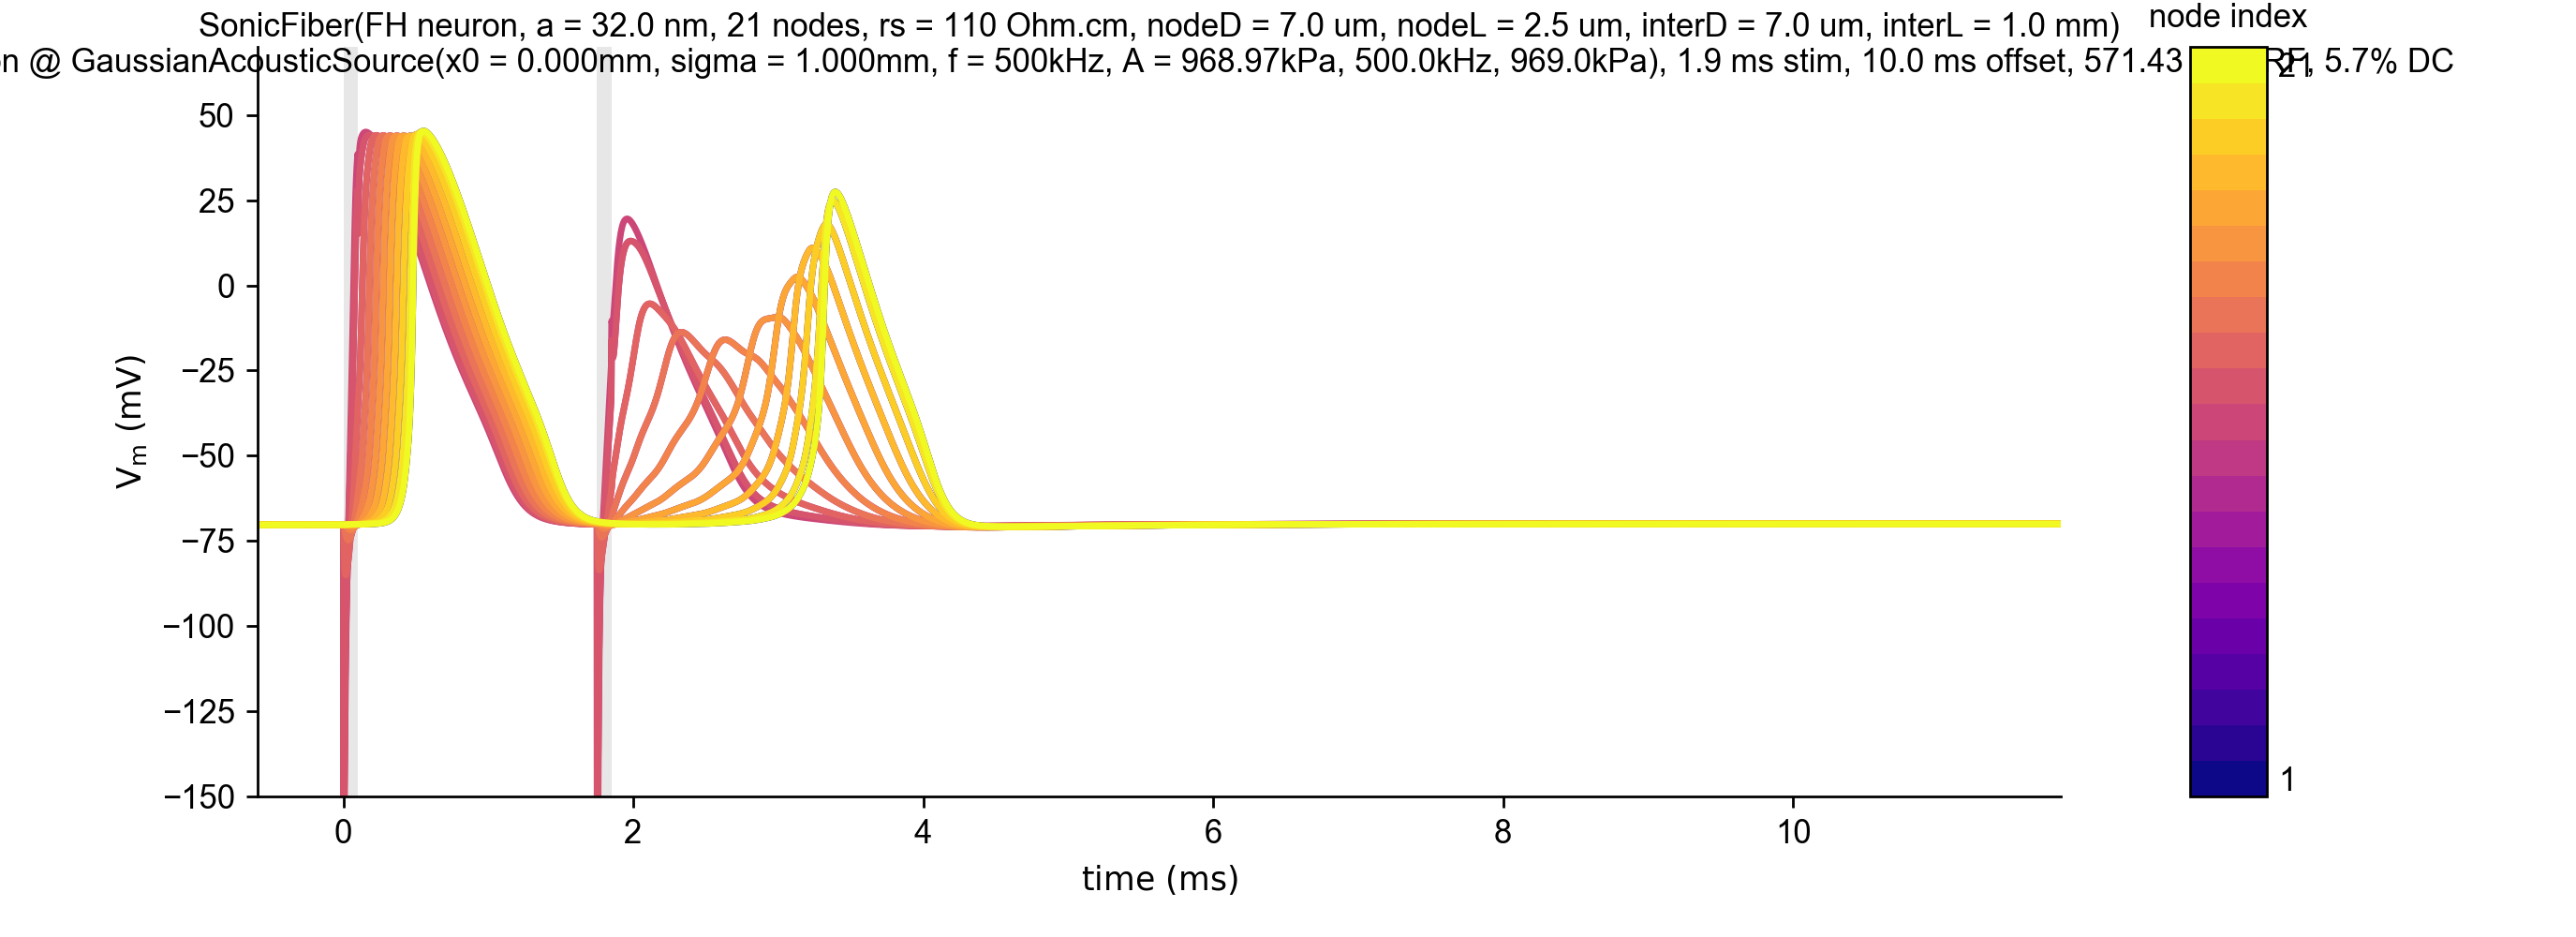

0.00165


In [77]:
source = GaussianAcousticSource(0, sigma, Fdrive, 10 * Athr)
toffset = 10e-3  # s
ton = 1e-4  # s
toff_range = np.linspace(1.5e-3, 2.5e-3, 21)
i = 0
double_spike = 0
while double_spike == 0:
    toff = toff_range[i]
    prf = 1 / (ton + toff)
    dc = ton * prf   # ton / (ton + toff)
    tstim = 1 / prf + ton
    pp = PulsedProtocol(tstim, toffset, prf, dc)
    data, meta= fiber.simulate(source, pp)
    nspikes_start = detectSpikes(data[fiber.ids[0]])[0].size
    nspikes_end = detectSpikes(data[fiber.ids[-1]])[0].size
    double_spike = (nspikes_start == nspikes_end) and (nspikes_start == 2)
    i = i + 1
fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
print(toff_range[i-1])

<IPython.core.display.Javascript object>


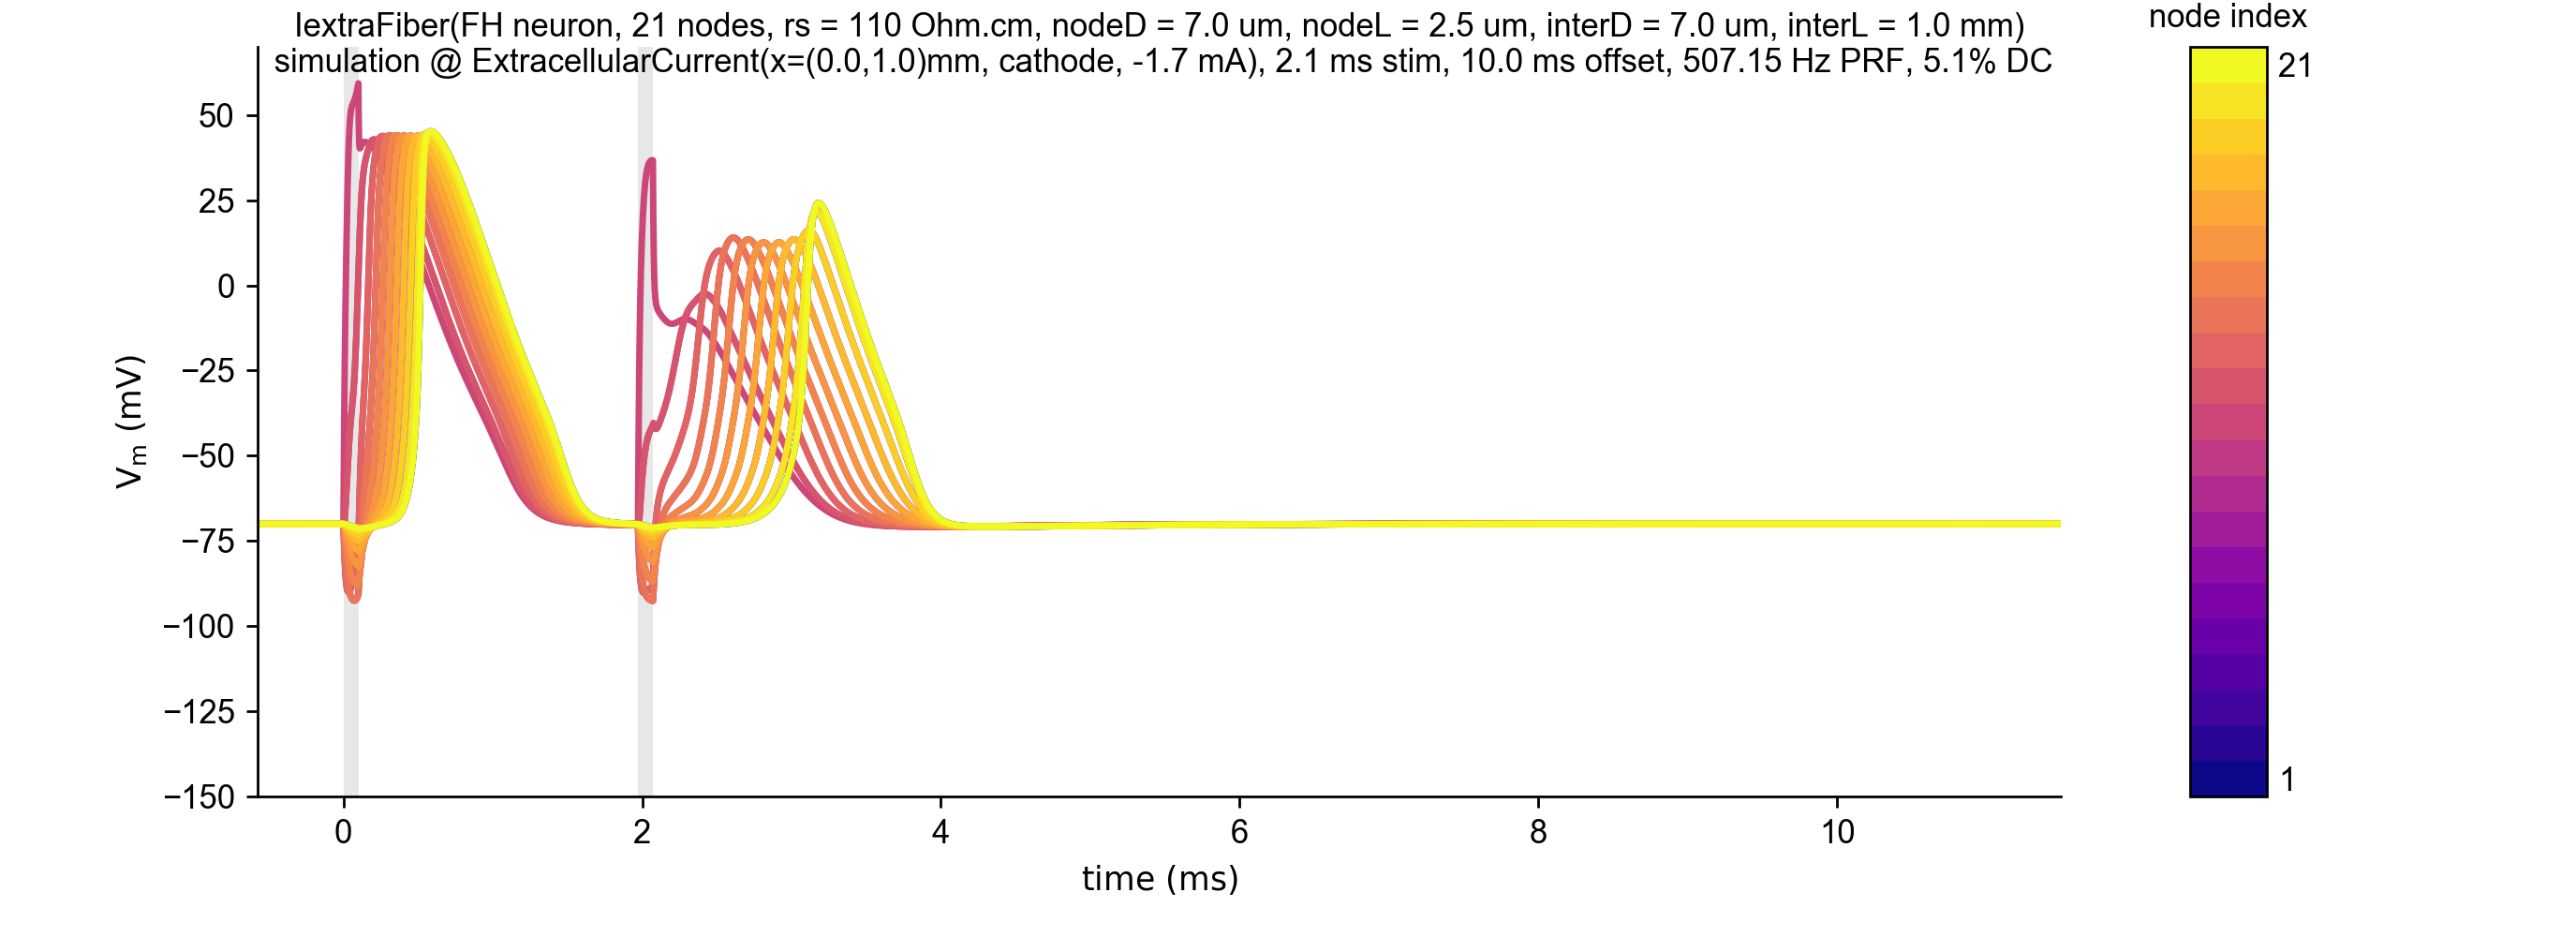

0.001871794871794872


In [79]:
%matplotlib notebook
fiber_class = IextraFiber
fiber = myelinatedFiberReilly(fiber_class, fiberD)
zdistance = 1e-3
source = ExtracellularCurrent((0, zdistance))
toffset = 10e-3 
ton = 1e-4  
pp = PulsedProtocol(ton, toffset)
Ithr = fiber.titrate(source, pp)
source = ExtracellularCurrent((0, zdistance), I=5 * Ithr)

toffset = 10e-3
ton = 1e-4
toff_range = np.linspace(1.5e-3, 16e-3, 40)
i = 0
double_spike = 0
while double_spike == 0:
    toff = toff_range[i]
    prf = 1 / (ton + toff)
    dc = ton / (ton + toff)  
    tstim = 2 * ton + toff
    pp = PulsedProtocol(tstim, toffset, prf, dc)
    data, meta= fiber.simulate(source, pp)
    #fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
    nspikes_start = detectSpikes(data[fiber.ids[0]])[0].size
    nspikes_end = detectSpikes(data[fiber.ids[-1]])[0].size
    double_spike = (nspikes_start == nspikes_end) and (nspikes_start == 2)
    i = i + 1
fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.ids).render()
print(toff_range[i-1])